# Functional API and Graph Operations

This tutorial demonstrates how to use BrainState's functional API for explicit state management using graph operations. This approach provides fine-grained control over model states and is particularly useful for advanced use cases like custom training loops and functional transformations.

## Learning Objectives

By the end of this tutorial, you will:
- Understand the functional API and graph operations in BrainState
- Learn how to split and merge model states using `treefy_split` and `treefy_merge`
- Build a training loop with explicit state management
- Apply JAX transformations with separated states
- Track custom states (e.g., function call counts)

## Setup and Imports

First, let's import the necessary libraries:

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import brainstate

# Set random seed for reproducibility
np.random.seed(42)

## Problem: Polynomial Regression

We'll solve a simple polynomial regression problem to demonstrate the functional API. Let's create a synthetic dataset:

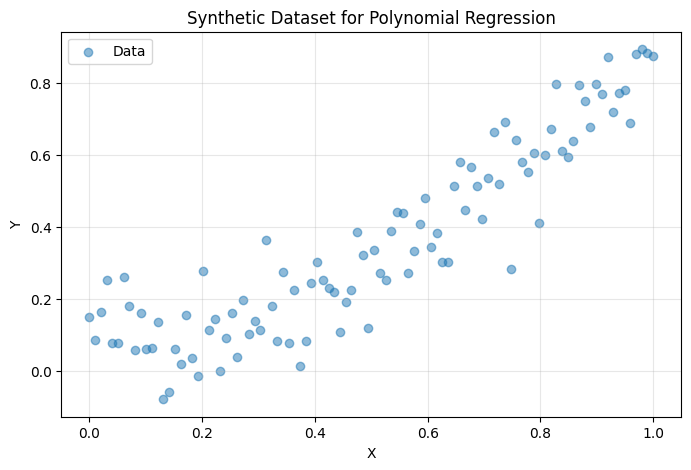

In [2]:
# Generate synthetic data: y = 0.8 * x^2 + 0.1 + noise
X = np.linspace(0, 1, 100)[:, None]
Y = 0.8 * X ** 2 + 0.1 + np.random.normal(0, 0.1, size=X.shape)

def dataset(batch_size):
    """Generator that yields random batches from the dataset."""
    while True:
        idx = np.random.choice(len(X), size=batch_size)
        yield X[idx], Y[idx]

# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X, Y, alpha=0.5, label='Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic Dataset for Polynomial Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Building the Model

### Step 1: Define Basic Components

First, let's create a simple `Linear` layer and a custom state type to track function calls:

In [3]:
class Linear(brainstate.nn.Module):
    """A simple linear layer: y = x @ w + b"""
    
    def __init__(self, din: int, dout: int):
        super().__init__()
        # Initialize weights and biases as trainable parameters
        self.w = brainstate.ParamState(brainstate.random.rand(din, dout))
        self.b = brainstate.ParamState(jnp.zeros((dout,)))
    
    def __call__(self, x):
        return x @ self.w.value + self.b.value


class Count(brainstate.State):
    """Custom state type for tracking function calls."""
    pass

### Step 2: Build the MLP Model

Now let's create a multi-layer perceptron (MLP) with a call counter:

In [4]:
class MLP(brainstate.graph.Node):
    """Multi-layer perceptron with call counting."""
    
    def __init__(self, din, dhidden, dout):
        # Custom state to count how many times the model is called
        self.count = Count(jnp.array(0))
        
        # Two linear layers
        self.linear1 = Linear(din, dhidden)
        self.linear2 = Linear(dhidden, dout)
    
    def __call__(self, x):
        # Increment call counter
        self.count.value += 1
        
        # Forward pass
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x

## Understanding Graph Operations

### What are Graph Operations?

BrainState models are represented as computational graphs where:
- **Nodes** represent modules or components
- **States** are the mutable variables within these nodes

Graph operations allow you to:
1. **Split** a model into its graph definition and separate state pytrees
2. **Merge** a graph definition with state pytrees to reconstruct the model

This is essential for functional programming with JAX, as it allows you to:
- Pass states as explicit function arguments
- Apply JAX transformations (jit, grad, vmap) to functions operating on states
- Manage different types of states independently (e.g., parameters vs. counters)

### Splitting the Model

Let's create a model and split it into its components:

In [5]:
# Create the model
model_initial = MLP(din=1, dhidden=32, dout=1)

# Split the model into graph definition and states
graphdef, params_, counts_ = brainstate.graph.treefy_split(
    model_initial, 
    brainstate.ParamState,  # Split out trainable parameters
    Count                    # Split out call counters
)

print("Graph definition (model structure):")
print(graphdef)
print("\nParameters (trainable weights):")
print(jax.tree.map(jnp.shape, params_))
print("\nCounters:")
print(counts_)

Graph definition (model structure):
NodeDef(
  type=MLP,
  index=0,
  attributes=('count', 'linear1', 'linear2'),
  subgraphs={
    'linear1': NodeDef(
      type=Linear,
      index=2,
      attributes=('_in_size', '_name', '_out_size', 'b', 'w'),
      subgraphs={
        '_in_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_name': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=None
        ),
        '_out_size': NodeDef(
          type=PytreeType,
          index=-1,
          attributes=(),
          subgraphs={},
          static_fields={},
          leaves={},
          metadata=PyTreeDef(None),
          index_mapping=N

**Key Points:**
- `graphdef`: Contains the model structure (immutable)
- `params_`: PyTree of trainable parameters (`ParamState`)
- `counts_`: PyTree of counters (`Count` state)

This separation is crucial because:
1. Only `params_` needs gradients during training
2. `counts_` needs to be updated but not differentiated
3. `graphdef` remains constant throughout training

## Functional Training Loop

### Step 1: Define Training Step

With separated states, we can create a pure functional training step:

In [6]:
@jax.jit
def train_step(params, counts, batch):
    """Perform one training step with explicit state management."""
    x, y = batch
    
    def loss_fn(params):
        # Merge graph definition with states to reconstruct the model
        model = brainstate.graph.treefy_merge(graphdef, params, counts)
        
        # Forward pass
        y_pred = model(x)
        
        # Extract updated counters (model was called, so count changed)
        new_counts = brainstate.graph.treefy_states(model, Count)
        
        # Compute loss
        loss = jnp.mean((y - y_pred) ** 2)
        
        return loss, new_counts
    
    # Compute gradients with respect to parameters
    grad, counts = jax.grad(loss_fn, has_aux=True)(params)
    
    # Simple SGD update: params = params - lr * grad
    params = jax.tree.map(lambda w, g: w - 0.1 * g, params, grad)
    
    return params, counts

**Understanding the Training Step:**

1. **Loss Function Definition:**
   - Takes `params` as input (what we differentiate)
   - Merges `graphdef`, `params`, and `counts` to reconstruct the model
   - Computes predictions and loss
   - Returns both loss and updated counts (auxiliary output)

2. **Gradient Computation:**
   - `jax.grad` computes gradients of loss w.r.t. parameters
   - `has_aux=True` allows returning both gradients and auxiliary values (counts)

3. **Parameter Update:**
   - Simple gradient descent: new_params = old_params - learning_rate * gradients
   - Uses `jax.tree.map` to apply the update to all parameters in the pytree

### Step 2: Define Evaluation Step

In [7]:
@jax.jit
def eval_step(params, counts, batch):
    """Evaluate the model on a batch."""
    x, y = batch
    
    # Reconstruct model
    model = brainstate.graph.treefy_merge(graphdef, params, counts)
    
    # Forward pass
    y_pred = model(x)
    
    # Compute loss
    loss = jnp.mean((y - y_pred) ** 2)
    
    return {'loss': loss}

### Step 3: Run Training

In [8]:
# Training parameters
total_steps = 10_000

# Training loop
print("Training the model...\n")
for step, batch in enumerate(dataset(32)):
    # Update parameters and counters
    params_, counts_ = train_step(params_, counts_, batch)
    
    # Log progress every 1000 steps
    if step % 1000 == 0:
        logs = eval_step(params_, counts_, (X, Y))
        print(f"Step: {step:5d}, Loss: {logs['loss']:.6f}")
    
    # Stop after total_steps
    if step >= total_steps - 1:
        break

print("\nTraining complete!")

Training the model...

Step:     0, Loss: 3.132510
Step:  1000, Loss: 0.007910
Step:  2000, Loss: 0.007855
Step:  3000, Loss: 0.007906
Step:  4000, Loss: 0.007970
Step:  5000, Loss: 0.007856
Step:  6000, Loss: 0.007849
Step:  7000, Loss: 0.007879
Step:  8000, Loss: 0.007893
Step:  9000, Loss: 0.007852

Training complete!


## Analyzing Results

### Reconstruct the Final Model

After training, we can merge the learned parameters back into a model:

In [9]:
# Reconstruct the trained model
model = brainstate.graph.treefy_merge(graphdef, params_, counts_)

# Check how many times the model was called during training
print(f"Total model calls during training: {model.count.value}")

# Make predictions on the full dataset
y_pred = model(X)

print(f"Final predictions shape: {y_pred.shape}")

Total model calls during training: 10000
Final predictions shape: (100, 1)


### Visualize Predictions

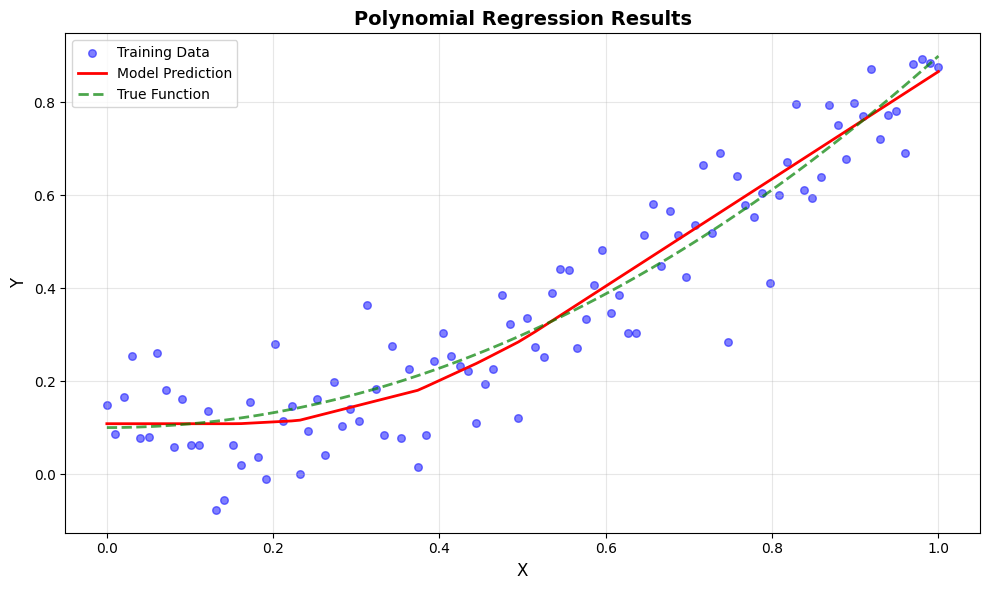

In [10]:
plt.figure(figsize=(10, 6))

# Plot data points
plt.scatter(X, Y, color='blue', alpha=0.5, label='Training Data', s=30)

# Plot predictions
plt.plot(X, y_pred, color='red', linewidth=2, label='Model Prediction')

# Plot true function
X_true = np.linspace(0, 1, 100)[:, None]
Y_true = 0.8 * X_true ** 2 + 0.1
plt.plot(X_true, Y_true, color='green', linewidth=2, 
         linestyle='--', label='True Function', alpha=0.7)

plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.title('Polynomial Regression Results', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Key Concepts Summary

### Graph Operations

1. **`treefy_split(model, *state_types)`**:
   - Splits a model into graph definition and state pytrees
   - Returns: `(graphdef, state1, state2, ...)`
   - Allows independent management of different state types

2. **`treefy_merge(graphdef, *states)`**:
   - Reconstructs a model from graph definition and states
   - Returns: Complete model with all states
   - Essential for functional API usage

3. **`treefy_states(model, state_type)`**:
   - Extracts states of a specific type from a model
   - Useful for getting updated states after forward pass

### Advantages of Functional API

1. **Explicit State Management**: Full control over which states are updated and how
2. **JAX Compatibility**: States are explicit function arguments, making JAX transformations straightforward
3. **Flexibility**: Separate handling of parameters, hidden states, and custom states
4. **Debugging**: Easier to track state changes and debug issues

### When to Use Functional API

- Custom training loops with complex state management
- Implementing advanced optimization algorithms
- Fine-grained control over gradient computation
- Functional programming style with JAX transformations
- Distributed training scenarios

## Exercises

Try these exercises to deepen your understanding:

1. **Add Momentum to SGD**:
   - Create a custom state type for momentum
   - Modify the training step to include momentum updates

2. **Track More Statistics**:
   - Add states to track training loss history
   - Add states to track gradient norms

3. **Implement Learning Rate Scheduling**:
   - Create a state for the current learning rate
   - Implement exponential decay or step decay

4. **Multi-Task Learning**:
   - Modify the MLP to have multiple output heads
   - Track separate counters for each task

## Next Steps

Now that you understand the functional API and graph operations, you can:

1. **Explore Lifted Transforms**: Learn about higher-level state management with automatic lifting
2. **Advanced Optimizers**: Use BrainTools optimizers that handle state management for you
3. **Complex Architectures**: Apply these concepts to recurrent networks and spiking neural networks
4. **Checkpointing**: Learn how to save and load model states

## References

- [BrainState Graph API Documentation](https://brainstate.readthedocs.io/en/latest/apis/graph.html)
- [JAX Transformations](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)
- [Flax Functional API](https://flax.readthedocs.io/en/latest/guides/flax_fundamentals/functional_api.html)